## Project 1
#### Summer 2021
**Authors:** GOAT Team (Estaban Aramayo, Ethan Haley, Claire Meyer, and Tyler Frankenburg)

The [Cocktail DB](https://www.thecocktaildb.com/api.php) is a database of cocktails and ingredients. In this assignment, we describe how we could use the Cocktail DB's API to generate a network of cocktails and ingredients. We can use some example data to explore how we might be able to predict outcomes from this data using centrality metrics. 

### Loading the Data

Without digging too deeply into the intricacies of the Cocktail DB API, we can leverage [this code](https://holypython.com/api-12-cocktail-database/) as a start for grabbing some example output from the API. This code leverages 2 libraries: `requests` to make an API request, and `json` to load the JSON output from the API. We can then iterate through each cocktail output to grab the relevant components. 

We can bulid a search query to pull all cocktail names (`strDrink`), the ingredients for each, and the drink categories (`strCategory`) for each cocktail.

First, we get all drinks, by first letter of name.

In [24]:
import networkx as net
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats

In [25]:
baseUrl = "https://www.thecocktaildb.com/api/json/v1/1/"
letterEndpoint = "search.php?f="

def searchLetter(letter):
    data = requests.get(baseUrl + letterEndpoint + letter)
    return json.loads(data.text)

In [26]:
# Build a dataframe
name = []  # drink name
ids = []   # drink ID
cat = []   # drink category
pic = []   # thumbnail url
ingr = []  # ingredients

In [27]:
# Helper function to parse ingredients
def ingreds(drinkDict):
    ing = []
    for i in range(1,16):  # API has 16 fields for ingredients of each drink, most of them empty/None
        s = "strIngredient" + str(i)
        if not d[s]:
            break
        ing.append(d[s])
    return ing

As we iterate through the letters, we make drinks Upper Case to distinguish from Ingredients, which may share the same name.

In [28]:
for l in 'abcdefghijklmnopqrstuvwxyz':
    
    drinks = searchLetter(l)['drinks']
    if not drinks: continue   #(some letters have no drinks)
    for d in drinks:
        name.append(str.upper(d['strDrink']))
        ids.append(d['idDrink'])
        cat.append(d['strCategory'])
        pic.append(d['strDrinkThumb'])
        ingr.append([str.lower(i) for i in ingreds(d)]) 

In [29]:
drinkDF = pd.DataFrame({'name': name,
                       'id': ids,
                       'category': cat,
                       'photoURL': pic,
                       'ingredients': ingr})
drinkDF.head()

,name,id,category,photoURL,ingredients
0,A1,17222,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[gin, grand marnier, lemon juice, grenadine]"
1,ABC,13501,Shot,https://www.thecocktaildb.com/images/media/dri...,"[amaretto, baileys irish cream, cognac]"
2,ACE,17225,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[gin, grenadine, heavy cream, milk, egg white]"
3,ADAM,17837,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[dark rum, lemon juice, grenadine]"
4,AT&T,13938,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[absolut vodka, gin, tonic water]"


### Bipartite Projections

Then, we can make a bipartite graph, with cocktails as one type and ingredients as the other.

In [30]:
from networkx.algorithms import bipartite

name = drinkDF.name.values
cat = drinkDF.category.values
ingr = drinkDF.ingredients.values

drinks = set(name)
ingreds = set(i for iList in ingr for i in iList)

B = net.Graph()
B.add_nodes_from(drinks, bipartite='Cocktail')
B.add_nodes_from(ingreds, bipartite='Ingredient')

for d in range(len(drinkDF)):
    B.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        B.add_edge(name[d], ing)

The bipartite graphs show us the connections between drinks (via shared ingredients) - this is what we'll focus on.

In [113]:
D = bipartite.weighted_projected_graph(B, drinks)
I = bipartite.weighted_projected_graph(B, ingreds)

### Break it down by Category

Ultimately, we want to compare centrality measures across our drink categories of interest: 'Cocktail','Ordinary Drink', and 'Shot'. We can create sub-dataframes of 3 key categories: 'cocktail', 'shot', and 'ordinary drink', that we can then compare key centrality measures across.

In [114]:
drinks_cocktails = drinkDF[(drinkDF['category']=="Cocktail")]
drinks_ordinary = drinkDF[(drinkDF['category']=="Ordinary Drink")]
drinks_shots = drinkDF[(drinkDF['category']=="Shot")]

First, we can look at our graph, colored by category: 

In [116]:
colors = []
for node in D:
    if node in drinks_cocktails.name.values:
        colors.append("lightblue")
    elif node in drinks_shots.name.values:
        colors.append("plum")
    elif node in drinks_ordinary.name.values:
        colors.append("gold")
    else: colors.append("lightgreen")      
#Node colors adapted from source: https://stackoverflow.com/a/59473049

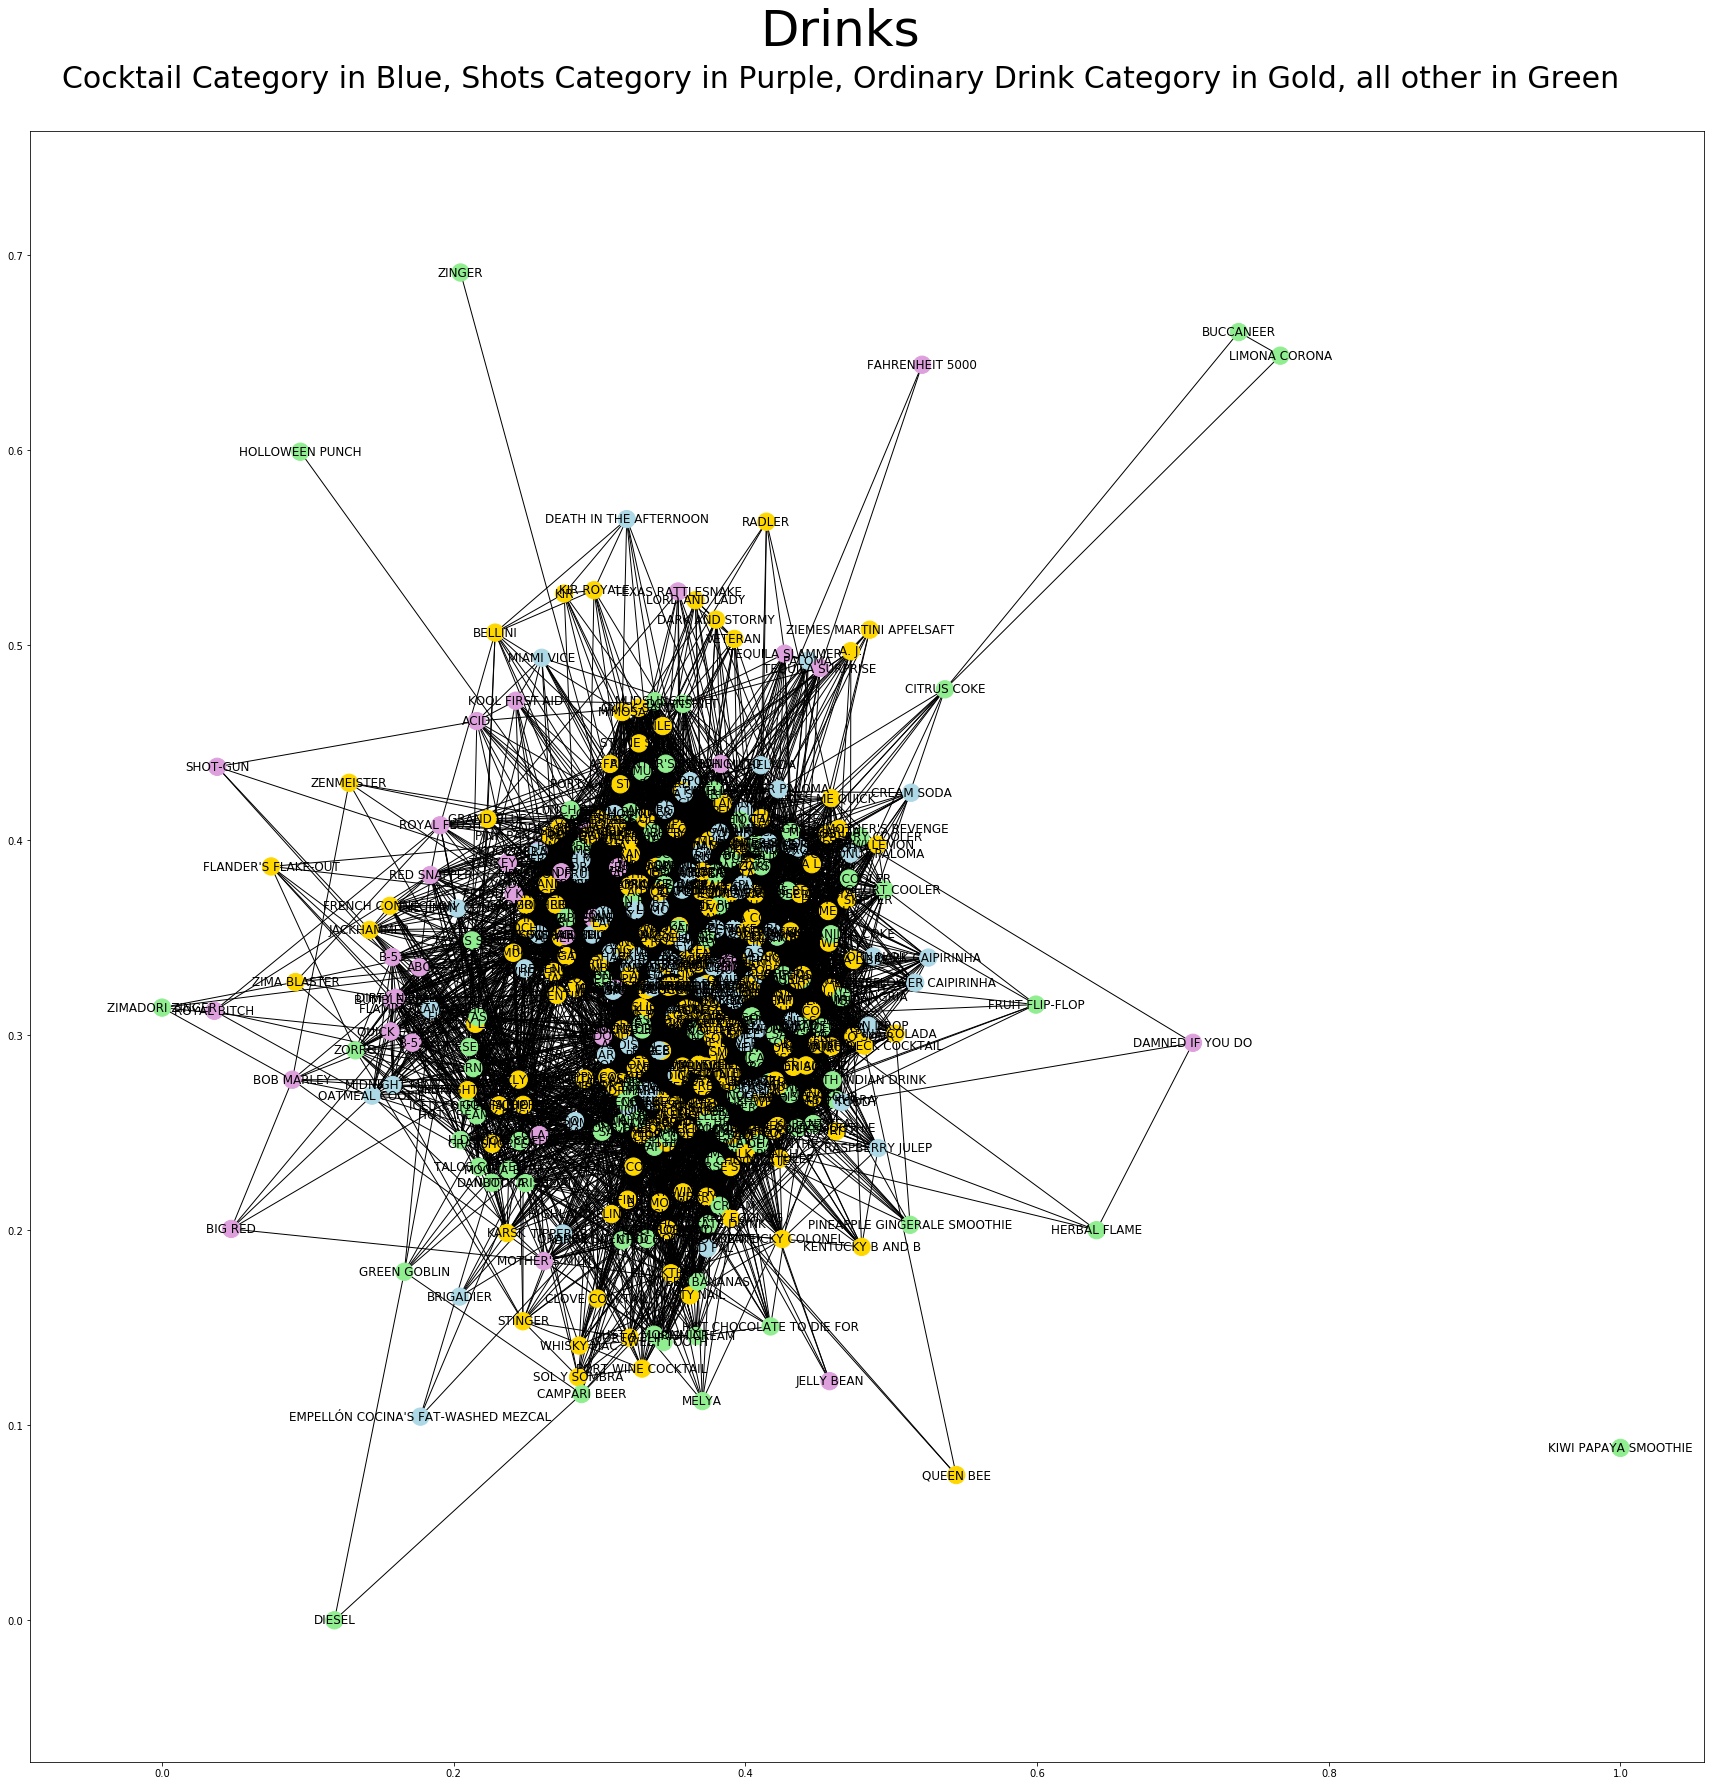

In [118]:
plt.figure(figsize = (30, 30))
ax = plt.subplot()

net.draw_networkx(D, ax=ax, node_color = colors)

plt.figtext(.5,.92,'Drinks', fontsize=50, ha='center')
plt.figtext(.5,.9, 'Cocktail Category in Blue, Shots Category in Purple, Ordinary Drink Category in Gold, all other in Green', fontsize = 30, ha='center')
plt.show()

That's challenging to interpret - so let's dig into our subsetted dataframes. We can create bipartite graphs for each category to prepare to compare centrality measures. We're going to focus on a bipartite projection of Drinks, to see which cocktails are connected by similar ingredients.

In [68]:
drinks_c = set(drinks_cocktails.name.values)
ingreds_c = set(i for iList in drinks_cocktails.ingredients.values for i in iList)

dc_graph = net.Graph()

dc_graph.add_nodes_from(drinks_c, bipartite='Drink')
dc_graph.add_nodes_from(ingreds_c,bipartite='Ingredient')

for d in drinks_cocktails.index:
    dc_graph.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        dc_graph.add_edge(name[d], ing)
        
bp_cocktail = bipartite.weighted_projected_graph(dc_graph, drinks_c)

Then we create a dataframe of degree and eigenvector centrality by each drink.

In [89]:
cocktail_degree = net.degree_centrality(bp_cocktail)
cocktail_degree = pd.DataFrame.from_dict(cocktail_degree, orient='index').reset_index()
cocktail_degree.head()

,index,0
0,PENICILLIN,0.166667
1,ESPRESSO MARTINI,0.202381
2,DARK CAIPIRINHA,0.083333
3,MARTINEZ 2,0.404762
4,ZIPPY'S REVENGE,0.071429


In [90]:
cocktail_eig = net.eigenvector_centrality_numpy(bp_cocktail)
cocktail_eig = pd.DataFrame.from_dict(cocktail_eig, orient='index').reset_index()

We repeat these steps across the two other categories: 

In [91]:
drinks_o = set(drinks_ordinary.name.values)
ingreds_o = set(i for iList in drinks_ordinary.ingredients.values for i in iList)

do_graph = net.Graph()

do_graph.add_nodes_from(drinks_o, bipartite='Drink')
do_graph.add_nodes_from(ingreds_o,bipartite='Ingredient')

for d in drinks_ordinary.index:
    dc_graph.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        do_graph.add_edge(name[d], ing)

bp_ordinary = bipartite.weighted_projected_graph(do_graph, drinks_o)

In [92]:
ordinary_degree = net.degree_centrality(bp_ordinary)
ordinary_degree = pd.DataFrame.from_dict(ordinary_degree, orient='index').reset_index()

In [93]:
ordinary_eig = net.eigenvector_centrality_numpy(bp_ordinary)
ordinary_eig = pd.DataFrame.from_dict(ordinary_eig, orient='index').reset_index()

In [94]:
drinks_s = set(drinks_shots.name.values)
ingreds_s = set(i for iList in drinks_shots.ingredients.values for i in iList)

ds_graph = net.Graph()

ds_graph.add_nodes_from(drinks_s, bipartite='Drink')
ds_graph.add_nodes_from(ingreds_s,bipartite='Ingredient')

for d in drinks_shots.index:
    ds_graph.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        ds_graph.add_edge(name[d], ing)
        
bp_shots = bipartite.weighted_projected_graph(ds_graph, drinks_s)  

In [95]:
shots_degree = net.degree_centrality(bp_shots)
shots_degree = pd.DataFrame.from_dict(shots_degree, orient='index').reset_index()

In [96]:
shots_eig = net.eigenvector_centrality_numpy(bp_shots)
shots_eig = pd.DataFrame.from_dict(shots_eig, orient='index').reset_index()

### Compare Centrality Measures across Categories
Now we're ready to compare the centrality values across our categories. We'll do this by: 
1. Create summary dataframe of both centrality measures for all categories.
2. Recombine category-level dataframes into one summary frame. 
3. Look at mean values by category. 
4. Check ANOVA assumptions + conduct ANOVA analysis. 


##### 1 and 2: Prepping Summary Dataframe

In [97]:
summary_cocktails = pd.merge(cocktail_degree, cocktail_eig, how = "inner", on = "index")
summary_cocktails = summary_cocktails.rename(columns = 
        {"index":"Name","0_x":"degree","0_y":"eigenvector"})
summary_cocktails['category'] = 'Cocktail'
summary_cocktails.head()

,Name,degree,eigenvector,category
0,PENICILLIN,0.166667,0.051796,Cocktail
1,ESPRESSO MARTINI,0.202381,0.051601,Cocktail
2,DARK CAIPIRINHA,0.083333,0.026845,Cocktail
3,MARTINEZ 2,0.404762,0.177213,Cocktail
4,ZIPPY'S REVENGE,0.071429,0.012238,Cocktail


In [98]:
summary_ordinary = pd.merge(ordinary_degree, ordinary_eig, how = "inner", on = "index")
summary_ordinary = summary_ordinary.rename(columns = 
        {"index":"Name","0_x":"degree","0_y":"eigenvector"})
summary_ordinary['category'] = 'Ordinary'
summary_ordinary.head()

,Name,degree,eigenvector,category
0,JOHN COLLINS,0.218274,0.079997,Ordinary
1,QUEEN BEE,0.015228,0.001364,Ordinary
2,SIDECAR,0.131980,0.030175,Ordinary
3,PINK LADY,0.395939,0.115986,Ordinary
4,GIN FIZZ,0.395939,0.145049,Ordinary


In [99]:
summary_shots = pd.merge(shots_degree, shots_eig, how = "inner", on = "index")
summary_shots = summary_shots.rename(columns = 
        {"index":"Name","0_x":"degree","0_y":"eigenvector"})
summary_shots['category'] = 'Shots'
summary_shots.head()

,Name,degree,eigenvector,category
0,BIG RED,0.060606,7.592322e-03,Shots
1,FLAMING DR. PEPPER,0.424242,2.517508e-01,Shots
2,ZIPPERHEAD,0.272727,1.822298e-01,Shots
3,FAHRENHEIT 5000,0.030303,-5.460652e-17,Shots
4,ABC,0.303030,2.427748e-01,Shots


In [100]:
summary_all = summary_cocktails
summary_all = summary_all.append([summary_shots,summary_ordinary])
summary_all.head()

,Name,degree,eigenvector,category
0,PENICILLIN,0.166667,0.051796,Cocktail
1,ESPRESSO MARTINI,0.202381,0.051601,Cocktail
2,DARK CAIPIRINHA,0.083333,0.026845,Cocktail
3,MARTINEZ 2,0.404762,0.177213,Cocktail
4,ZIPPY'S REVENGE,0.071429,0.012238,Cocktail


##### 3: Comparing Mean and Median Values

Then we can use our summary table to compare mean and median values. We see 'Shots' has lower Degree centrality, but higher Eigenvector centrality in terms of both Mean and Median.

In [101]:
grouped_summary = summary_all.groupby("category")
mean_grouped = grouped_summary.mean()
mean_grouped

,degree,eigenvector
category,,
Cocktail,0.229132,0.085437
Ordinary,0.222684,0.053936
Shots,0.165775,0.129288


In [102]:
median_grouped = grouped_summary.median()
median_grouped

,degree,eigenvector
category,,
Cocktail,0.226190,0.069718
Ordinary,0.213198,0.037793
Shots,0.181818,0.117100


##### 4: Check ANOVA Assumptions and Conduct ANOVA Test

ANOVA tests are useful to compare mean values across multiple categories, versus a 2-sample test for example. This analysis will tell us if our means are materially diffferent by group. 

The code below is repurposed from a tutorial [here](https://towardsdatascience.com/anova-test-with-python-cfbf4013328b). 

Before we start the analysis, we should check our ANOVA assumptions, namely: 
- Independence, which we can assume to be true.
- Normally distributed values within each group
- Equal variances between all groups

To start, we compare a box plot across the categories. These plots suggest there are not huge differences between Cocktails and Ordinary Drinks, but one outlier.

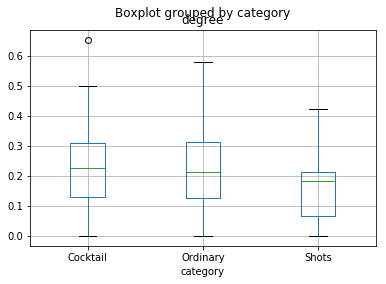

In [103]:
summary_all.boxplot('degree',by='category')

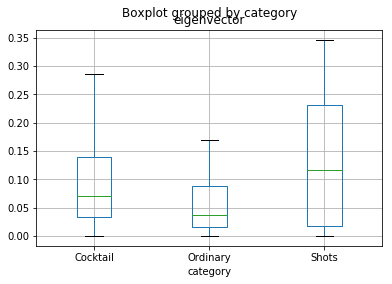

In [104]:
summary_all.boxplot('eigenvector',by='category')

First, we check for normality in both centrality metrics. We find that, particularly for Degree centrality, there is nor a normal distribution. 

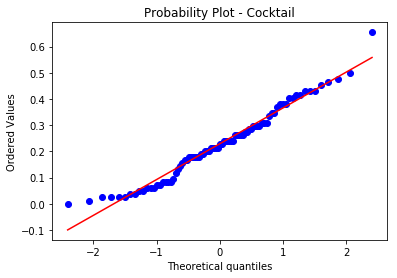

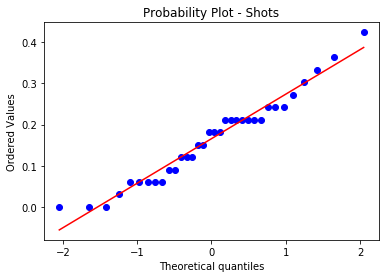

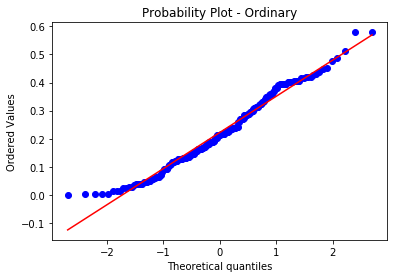

In [105]:
unique_cat = summary_all['category'].unique()
for category in unique_cat:
    stats.probplot(summary_all[summary_all['category'] == category]['degree'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  category)
    plt.show()

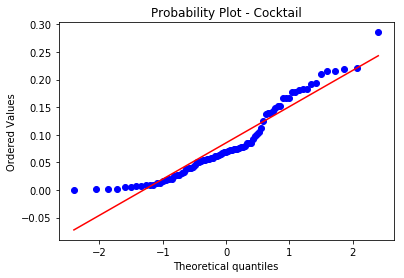

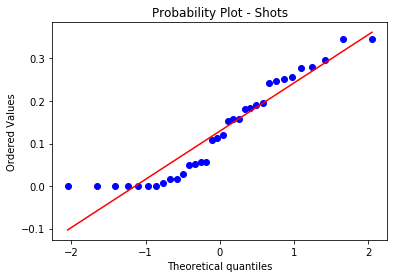

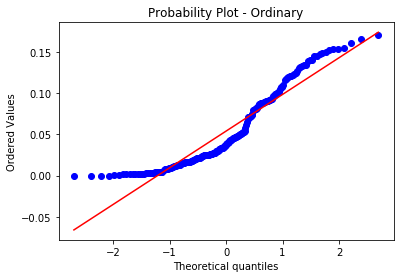

In [106]:
unique_cat = summary_all['category'].unique()
for category in unique_cat:
    stats.probplot(summary_all[summary_all['category'] == category]['eigenvector'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  category)
    plt.show()

Then we check for the ratio of the largest and smallest standard deviation, looking for values below '2'. Eigenvector does not meet that condition, so we will take those findings directionally. 

In [107]:
ratio = summary_all.groupby('category').std().max() / summary_all.groupby('category').std().min()
ratio

degree         1.286672
eigenvector    2.465349
dtype: float64

Despite assumptions not being perfectly met, we can move forward with the analysis and exercise caution with the results. The code below follows the tutorial linked above, and creates an ANOVA table, then interprets results. 

In our case, our NULL hypothesis is that there is no difference between groups. 

In [108]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = summary_all['degree'].mean()
SSTR = summary_all.groupby('category').count() * (summary_all.groupby('category').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['degree'].sum()

# calculate SSE and update anova table
SSE = (summary_all.groupby('category').count() - 1) * summary_all.groupby('category').std()**2
anova_table['SS']['Within Groups'] = SSE['degree'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['degree'].sum() + SSE['degree'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = summary_all['category'].nunique() - 1
anova_table['df']['Within Groups'] = summary_all.shape[0] - summary_all['category'].nunique()
anova_table['df']['Total'] = summary_all.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Print final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,0.107578,2,0.053789,3.246309,0.040228,3.732558
Within Groups,5.202745,314,0.016569,,,
Total,5.310323,316,0.016805,,,


In [109]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 3.246308885694335  and p value is: 0.040227585835691526
Failed to reject the null hypothesis.


We do not reject the null hypothesis - the centrality values in this bipartite projection graph are not statistically significantly different by category.

### Highest Centrality Nodes

Finally, let's look at the drinks with the highest values for each of our metrics. 

In [110]:
summary_all.sort_values(by=['degree'],ascending=False).head()

,Name,degree,eigenvector,category
74,JITTERBUG,0.654762,0.285723,Cocktail
38,LONG ISLAND ICED TEA,0.578680,0.132504,Ordinary
155,LONG ISLAND TEA,0.578680,0.138789,Ordinary
39,ROSE,0.512690,0.170203,Ordinary
31,GIMLET,0.500000,0.220124,Cocktail


In [111]:
summary_all.sort_values(by=['eigenvector'],ascending=False).head()

,Name,degree,eigenvector,category
16,BUMBLE BEE,0.212121,0.346579,Shots
21,DIRTY NIPPLE,0.212121,0.346579,Shots
17,B-52,0.181818,0.296153,Shots
74,JITTERBUG,0.654762,0.285723,Cocktail
7,QUICK F**K,0.212121,0.279150,Shots


Highest Degree centrality nodes are all in the Cocktail and Ordinary categories, while Eigenvector is dominated by Shots. This makes sense - common cocktials will have more ingredients, while Shots are more likely to contain "foundational" ingredients.

The most important cocktail by Degree centrailty is a [Jitterbug](https://www.thecocktaildb.com/drink/16178-Jitterbug). 

![Jitterbug](https://www.thecocktaildb.com/images/media/drink/wwqvrq1441245318.jpg)

And the important cocktail by Eigenvector centrality is a [Bumble Bee](https://www.thecocktaildb.com/drink/14538-Bumble-Bee)

![Bumble Bee](https://www.thecocktaildb.com/images/media/drink/uwqpvv1461866378.jpg)